In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid


import torch.nn as nn
import torch.nn.functional as F

import torchinfo

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.facecolor"] ="#ffffff"

# Explore CIFAR10

In [2]:
# Dowload dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, ".")

Using downloaded and verified file: ./cifar10.tgz


In [3]:
with tarfile.open("./cifar10.tgz", "r:gz") as tar:
    tar.extractall(path="./data")

In [4]:
data_dir = "./data/cifar10/"

In [5]:
print(os.listdir(data_dir))

['test', 'train']


In [6]:
classes = os.listdir(data_dir + "/train")
classes

['automobile',
 'airplane',
 'ship',
 'frog',
 'truck',
 'dog',
 'bird',
 'cat',
 'horse',
 'deer']

In [7]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print("No. of training examples for airplanes: ", len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes:  5000
['0763.png', '1503.png', '3790.png', '0593.png', '4059.png']


In [8]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of testing examples for ship: ", len(ship_test_files))
print(ship_test_files[:5])

No. of testing examples for ship:  1000
['0763.png', '0593.png', '0104.png', '0254.png', '0208.png']


# Load original dataset by 
```python
ImageFolder 
```


In [9]:
# ImageFolder to load image files
dataset = ImageFolder(data_dir + "/train", transform=ToTensor())

In [10]:
img, label = dataset[0]
print(img.shape, label)
# img

torch.Size([3, 32, 32]) 0


In [11]:
# print(f"The dataset shape: [{len(dataset)},{str(tuple(img.shape))}]")
img_shape = " ".join([str(num) for num in list(img.shape)])
print(f"The dataset shape: [{len(dataset)},{img_shape}]")

The dataset shape: [50000,3 32 32]


In [12]:
str(tuple(img.shape))

'(3, 32, 32)'

In [13]:
dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Loading dataset

In [14]:
dataset = ImageFolder(data_dir + "/" + "train", transform=ToTensor())
len(dataset)

50000

In [15]:
def data_loader(data_dir="./data/cifar10", mode='train', cls_inx=0):
    """
    Load the image from the file path, 
    check the image shape,
    plot the image
    """
    dataset = ImageFolder(data_dir + "/" + mode, transform=ToTensor())
    img, label = dataset[cls_inx]
    img_shape = " ".join([str(num) for num in list(img.shape)])
    print(f"The dataset shape: [{len(dataset)},{img_shape}]")
    print(f"Image shape: {img_shape}")
    print("The img: ", dataset.classes[label], " - class ("+str(label)+")")
    plt.imshow(img.permute(1,2,0), cmap="gray")
    plt.show()

The dataset shape: [50000,3 32 32]
Image shape: 3 32 32
The img:  deer  - class (4)


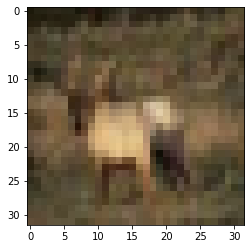

In [16]:
data_loader(cls_inx = 20000)

The dataset shape: [50000,3 32 32]
Image shape: 3 32 32
The img:  truck  - class (9)


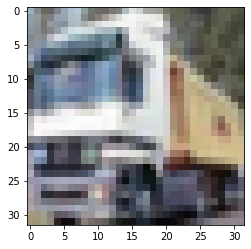

In [17]:
data_loader(cls_inx = 45000)

In [18]:
random_seed = 42
torch.manual_seed(random_seed)

In [19]:
val_size = 5000
train_size = len(dataset) - val_size
print(train_size, val_size)

45000 5000


# Train test split

In [20]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])  # random split the dataset with trian and val
print(len(train_ds), len(val_ds))

45000 5000


In [21]:
batch_size = 128

In [22]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [23]:
def show_batch(dataloader):
    for imgs, lbls in dataloader:
        fig, ax = plt.subplots(figsize=(12, 6))
        # configure the x and y axies label to be blank
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(imgs, nrow=16).permute(1,2,0))
        break

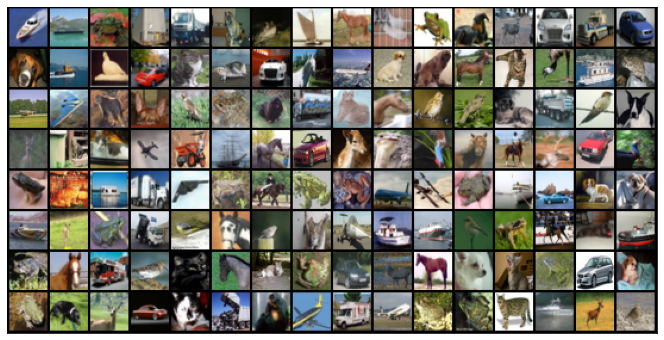

In [24]:
show_batch(train_dl)

In [25]:
def apply_kernel(img, kernel):
    """
    ri - row image
    ci - column image
    rk - row kernel
    ck - column kernel
    ro - row output
    co - column output
    
    formula to compute the shape of output in cnn, where p is the padding, s is the stride step of kernel
    output-row = floor((ri - rk + 2p) /s ) + 1    
    output_col = floor((ci - ck + 2p) /s ) + 1
    
    """
    ri, ci = img.shape
    rk, ck = kernel.shape
    ro, co = ri - rk + 1, ci - ck + 1
    output = torch.zeros([ro, co])
    for i in range(ro):
        """
        convolution computation
        """
        for j in range(co):
            output[i, j] = torch.sum(img[i:i+rk, j:j+ck] * kernel)
    return output

In [26]:
# test of convolution computation
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype = torch.float32)

In [27]:
apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [28]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2,2)
)

In [29]:
for imgs, labels in train_dl:
    print("imgs.shape: ", imgs.shape)
    out = simple_model(imgs)
    print("out.shape: ", out.shape)
    break

imgs.shape:  torch.Size([128, 3, 32, 32])
out.shape:  torch.Size([128, 8, 16, 16])


`Conv-Pool example`
<img src="https://i.imgur.com/KKtPOKE.png" style="max-width:540px">

In [30]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [31]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [32]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [33]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [34]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0239, -0.0466,  0.0067,  0.0193,  0.0044, -0.0598, -0.0188, -0.0242,
         0.0431, -0.0164], grad_fn=<SelectBackward0>)


In [35]:
torchinfo.summary(model, input_size=(128, 3, 32, 32))

/home/loveplay1983/Workstation/Anaconda/anaconda/envs/torch/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
Cifar10CnnModel                          [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 32, 32, 32]         896
│    └─ReLU: 2-2                         [128, 32, 32, 32]         --
│    └─Conv2d: 2-3                       [128, 64, 32, 32]         18,496
│    └─ReLU: 2-4                         [128, 64, 32, 32]         --
│    └─MaxPool2d: 2-5                    [128, 64, 16, 16]         --
│    └─Conv2d: 2-6                       [128, 128, 16, 16]        73,856
│    └─ReLU: 2-7                         [128, 128, 16, 16]        --
│    └─Conv2d: 2-8                       [128, 128, 16, 16]        147,584
│    └─ReLU: 2-9                         [128, 128, 16, 16]        --
│    └─MaxPool2d: 2-10                   [128, 128, 8, 8]          --
│    └─Conv2d: 2-11                      [128, 256, 8, 8]          295,

# Sending data to GPU(CUDA)

In [36]:
# Using GPU
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [37]:
class DeviceDataLoader():
    """
    Send data to device by wrapping dataloader
    """
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """
        yield batch of data after send the data to device
        """
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

In [38]:
device = get_default_device()
device

device(type='cuda')

In [39]:
for imgs, labels in train_dl:
    print('images.shape:', imgs.shape)
    imgs = imgs.to(device)
    out = model(imgs)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0239, -0.0468,  0.0068,  0.0192,  0.0043, -0.0599, -0.0187, -0.0242,
         0.0430, -0.0164], device='cuda:0', grad_fn=<SelectBackward0>)


In [40]:
# move model weight to cuda or cpu
# cifar10_test.cpu()
# cifar10_test.cuda()

In [41]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Model training

In [42]:
@torch.no_grad()
def evaluate(model, val_loader):
    """
    decorator in PyTorch is used to temporarily disable gradient calculation 
    within the decorated function. This means that any operations performed 
    on tensors inside the function will not be tracked for backpropagation.
    """
    model.eval()  # set model to evaluation mode
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [43]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func =torch.optim.SGD):
    """
    After set up the model, help functions, fit function will help to actually perform 
    the training step and combine all the tools 
    """
    history = []
    optimizer = opt_func(model.parameters(), lr) # config optimizer by model params and learning rate
    for epoch in range(epochs):
        # Training mode
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()   # backpropagation
            optimizer.step()  # perform optimization
            optimizer.zero_grad() # zero out the previous computation after the optimization step
            
            
        # Validation
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history
            

In [44]:
device

device(type='cuda')

In [45]:
model = to_device(Cifar10CnnModel(), device)

In [46]:
evaluate(model, val_dl)

{'val_loss': 2.302286148071289, 'val_acc': 0.10965073108673096}

In [47]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = .001

In [48]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7274, val_loss: 1.3826, val_acc: 0.4758
Epoch [1], train_loss: 1.1998, val_loss: 1.0868, val_acc: 0.6005
Epoch [2], train_loss: 0.9242, val_loss: 0.8939, val_acc: 0.6869
Epoch [3], train_loss: 0.7404, val_loss: 0.7774, val_acc: 0.7285
Epoch [4], train_loss: 0.5988, val_loss: 0.7378, val_acc: 0.7489
Epoch [5], train_loss: 0.4703, val_loss: 0.7299, val_acc: 0.7592
Epoch [6], train_loss: 0.3650, val_loss: 0.7539, val_acc: 0.7572
Epoch [7], train_loss: 0.2709, val_loss: 0.8325, val_acc: 0.7638
Epoch [8], train_loss: 0.2056, val_loss: 0.9044, val_acc: 0.7733
Epoch [9], train_loss: 0.1544, val_loss: 0.9612, val_acc: 0.7626


In [50]:
def plot_hist(history, acc=None, loss=None):
    if acc == "acc":
        accuracies = [x["val_acc"] for x in history]
        plt.plot(accuracies, "-x")
        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.title("Accuracy vs Num of epochs")
        plt.show()
    elif loss == "loss":
        train_losses = [x.get("train_loss") for x in history]
        val_losses = [x["val_loss"] for x in history]
        plt.plot(train_losses, "-bx")
        plt.plot(val_losses, "-rx")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend(["Training", "Validation"])
        plt.title("Loss vs Num of epochs")
        plt.show()

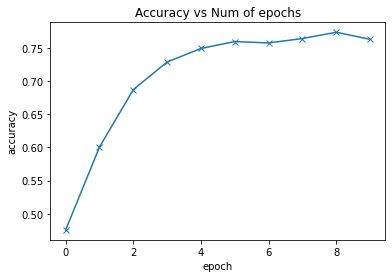

In [51]:
plot_hist(history, acc="acc")

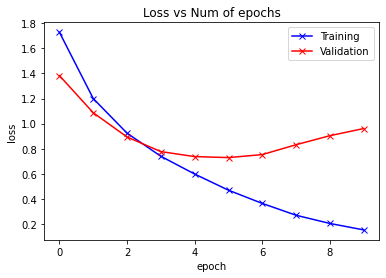

In [52]:
plot_hist(history, loss="loss")

# Testing with individual images

In [53]:
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [54]:
test_dataset = ImageFolder(data_dir + "/test", transform=ToTensor())

In [55]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 10000
    Root location: ./data/cifar10//test
    StandardTransform
Transform: ToTensor()

In [56]:
def predict_image(data, index, model):
    img, label = data[index]
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    pred_item = dataset.classes[preds[0].item()] # retrieve the cls label
    print(f"Label: {dataset.classes[label]},\nPredicted: {pred_item}")
    plt.imshow(img.permute(1,2,0))
    plt.show()

Label: airplane,
Predicted: airplane


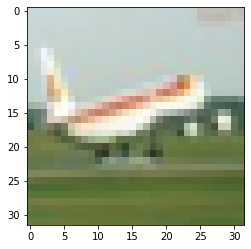

Label: airplane,
Predicted: ship


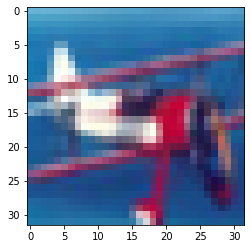

Label: automobile,
Predicted: automobile


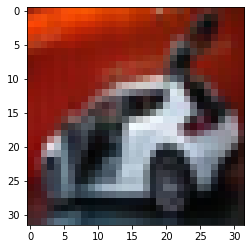

Label: dog,
Predicted: dog


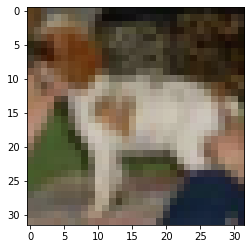

Label: ship,
Predicted: ship


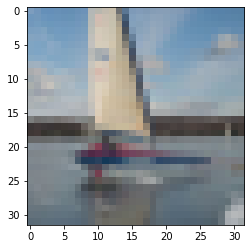

Label: truck,
Predicted: truck


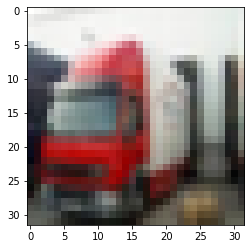

In [57]:
for inx in (100,888, 1000,5000,8888,9999):
    predict_image(test_dataset, inx, model)

In [58]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.9791147112846375, 'val_acc': 0.761035144329071}

# Model saving and loading


In [59]:
torch.save(model.state_dict(), "cifar10-cnn.pth")

In [60]:
model_test = to_device(Cifar10CnnModel(), device)

In [61]:
model_test.load_state_dict(torch.load("./cifar10-cnn.pth"))

<All keys matched successfully>

In [62]:
evaluate(model_test, test_loader)

{'val_loss': 0.9791147112846375, 'val_acc': 0.761035144329071}